# < 제주 읍면동별, 위치별 총이용금액 분석 >
## * 총 이용금액과 건수를 기준으로 시각화를 진행했습니다. 
## 먼저, 해보고싶은 데이터 탐색을 진행해 봤구요. 읍면동별 시각화는 그래프보단 맵상에서 표현하는게 맞다고 생각하여 leaflet을 이용해 시각화했고 파일이 커져서 샤이니에 따로 띄어서 보여드렸습니다. 추후 수정 업로드 할 예정입니다.



### <별도로 이용한데이터>
* http://map.ngii.go.kr/ms/map/NlipMap.do?tabGb=statsMap (국토정보플랫폼 국토정보맵 - 법정동 생산가능인구)
* http://data.nsdi.go.kr/dataset/15145 (국가공간정보포털 - 행정구역_읍면동(법정))
<br>이 shp데이터를 이용해 제공된 데이터와 맵핑하여 사용했습니다.

# 목차
## 1. 데이터 로드 <br>2. 데이터 탐색 <br>3. 읍면동별 시각화(leaflet R shiny)

## 1. 데이터 로드

### 작업디렉토리 설정, 필요한 라이브러리 설치 및 로드

In [3]:
getwd()
setwd("C:/Users/USER/Documents/sh_R/jeju_gis")
library(tidyverse)
library(extrafont)
library(ggplot2)
library(RColorBrewer)
library(scales)
library(gridExtra)
library(reshape2)
library(leaflet)
library(leaflet.extras)
library(htmltools)
library(htmlwidgets)
library(rgdal)
library(sp)
#font_import(pattern = 'NanumGothic')
loadfonts()
loadfonts(dev="win")
windowsFonts()
theme_update(text=element_text(family="NanumGothic"))

[1] "C:/Users/USER/Documents/sh_R/jeju_gis"

NanumGothic already registered with pdfFonts().
NanumGothicExtraBold already registered with pdfFonts().
NanumGothic Light already registered with pdfFonts().
NanumGothic already registered with windowsFonts().
NanumGothicExtraBold already registered with windowsFonts().
NanumGothic Light already registered with windowsFonts().


$serif
[1] "TT Times New Roman"

$sans
[1] "TT Arial"

$mono
[1] "TT Courier New"

$NanumGothic
[1] "NanumGothic"

$NanumGothicExtraBold
[1] "NanumGothicExtraBold"

$`NanumGothic Light`
[1] "NanumGothic Light"

### 데이터 로드

In [4]:
options(digits = 10)
dat5 <- read.table('KRI-DAC_Jeju_data5.txt', fileEncoding = 'UTF-8', sep = ',', header = TRUE)
dat6 <- read.table('KRI-DAC_Jeju_data6.txt', fileEncoding = 'UTF-8', sep = ',', header = TRUE)
dat7 <- read.table('KRI-DAC_Jeju_data7.txt', fileEncoding = 'UTF-8', sep = ',', header = TRUE)
dat8 <- read.table('KRI-DAC_Jeju_data8.txt', fileEncoding = 'UTF-8', sep = ',', header = TRUE)
dat7 %>%
  select(-X, -Y) -> dat7

### 데이터 정제 및 전처리

* 시간대를 데이터 명세에 따라 같이 나눠 timeName이라는 변수를 하나 만들어 줬습니다. 그리고 좌표계를 위경도 좌표계(WGS84)로 변경해 주었구요.

In [8]:
dat <- rbind(dat5,dat6,dat7,dat8)
dat$YM <- as.character(dat$YM)
dat <- dat %>%
  select(-OBJECTID, -Field1)

# dat %>%
#   mutate(SIGUNGU = ifelse(SIGUNGU == '제주시', 'jeju-si', 'seoguipo-si')) -> dat
dat <- dat %>%
  mutate(timeName = ifelse(Time %in% c('03시','04시','05시', '06시'), '새벽', 
                           ifelse(Time %in% c('07시','08시','09시','10시','11시'), '오전',
                                  ifelse(Time %in% c('12시','13시','14시'), '점심', 
                                         ifelse(Time %in% c('15시','16시','17시','18시'), '오후',
                                                ifelse(Time %in% c('19시','20시','21시', '22시'), '저녁',
                                                       ifelse(Time  %in% c('23시','00시','01시','02시'), '심야', '무승인')))))))
## 좌표계변환 
convertCoordSystem <- function(long, lat, from.crs, to.crs){
  xy <- data.frame(long=long, lat=lat)
  coordinates(xy) <- ~long+lat
  
  from.crs <- CRS(from.crs)
  from.coordinates <- SpatialPoints(xy, proj4string=from.crs)
  
  to.crs <- CRS(to.crs)
  changed <- as.data.frame(SpatialPoints(spTransform(from.coordinates, to.crs)))
  names(changed) <- c("long", "lat")
  
  return(changed)
}
from.crs = "+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
# from.crs = "+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs" 
to.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" # 위경도 좌표계
coord <- convertCoordSystem(dat$POINT_X, dat$POINT_Y, from.crs, to.crs)
dat <- cbind(dat, coord)
rm(coord); rm(from.crs); rm(to.crs); rm(convertCoordSystem);
rm(dat5);rm(dat6);rm(dat7);rm(dat8);

#write.csv(dat, 'KRI_DAC_Jeju.csv') # 데이터 저장
dat <- read.csv('KRI_DAC_Jeju.csv')

dat$timeName <- factor(dat$timeName, levels = c('새벽','오전','점심','오후','저녁','심야','무승인'))

ERROR: Error in rbind(dat5, dat6, dat7, dat8): 객체 'dat5'를 찾을 수 없습니다


## 2. EDA 시각화

### 제주시, 서귀포시 5~8월까지 총 이용금액 비교

* 제주시와 서귀포시를 나눠 5~8월까지의 총 이용금액을 비교해 봤습니다.<br>
결과는 제주시와 서귀포가 약 3배 차이가 났습니다

`summarise()` ungrouping output (override with `.groups` argument)


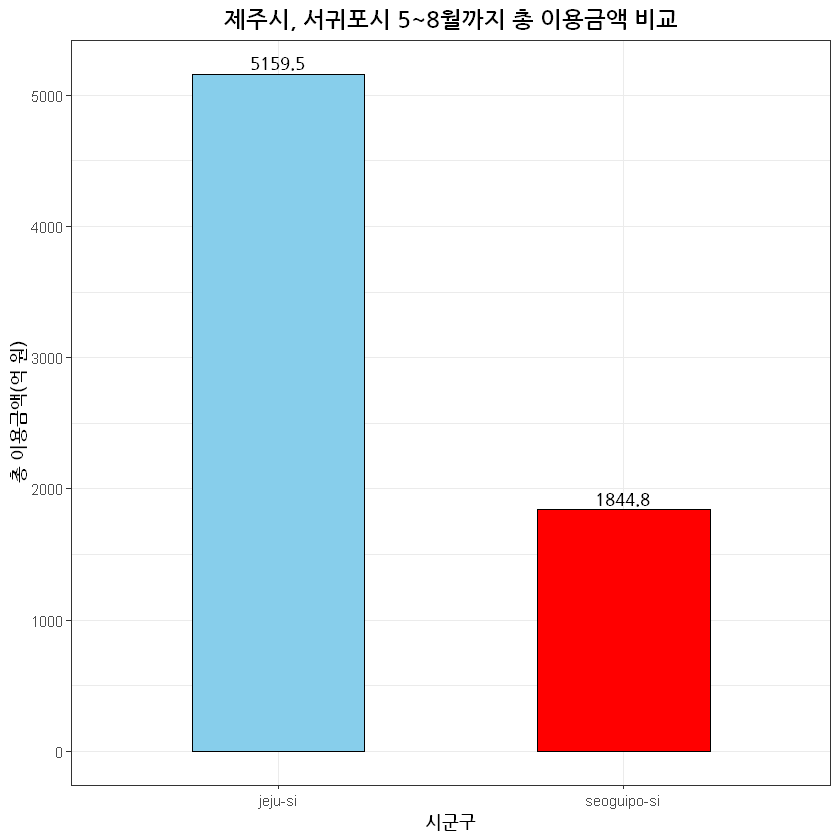

In [9]:
dat %>%
  group_by(SIGUNGU) %>% 
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  ggplot(aes(x = SIGUNGU, y = TotalSpent_sum, fill = SIGUNGU)) +
  geom_bar(stat='identity', color = 'black', width = 0.5) +
  geom_text(aes(label=TotalSpent_sum), vjust=-0.4, size = 3.5, family = 'NanumGothic', fontface = 'bold') +
  scale_fill_manual(values = c('skyblue', 'red')) + 
  theme_bw() +
  ggtitle("제주시, 서귀포시 5~8월까지 총 이용금액 비교") +
  labs(x = "시군구", y = "총 이용금액(억 원)") +
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none')

### 시별 월별 총 이용금액 비교

* 그리고 월별 시별로도 비교해보기 위해 시각화를 진행했구요. 모두 3배 정도 제주시가 더 컸습니다. <br>
20년 9월 기준 제주시의 인구 약 50만명, 서귀포 약19만명으로 보면 당연한 결과라고 생각합니다.

`summarise()` regrouping output by 'SIGUNGU' (override with `.groups` argument)


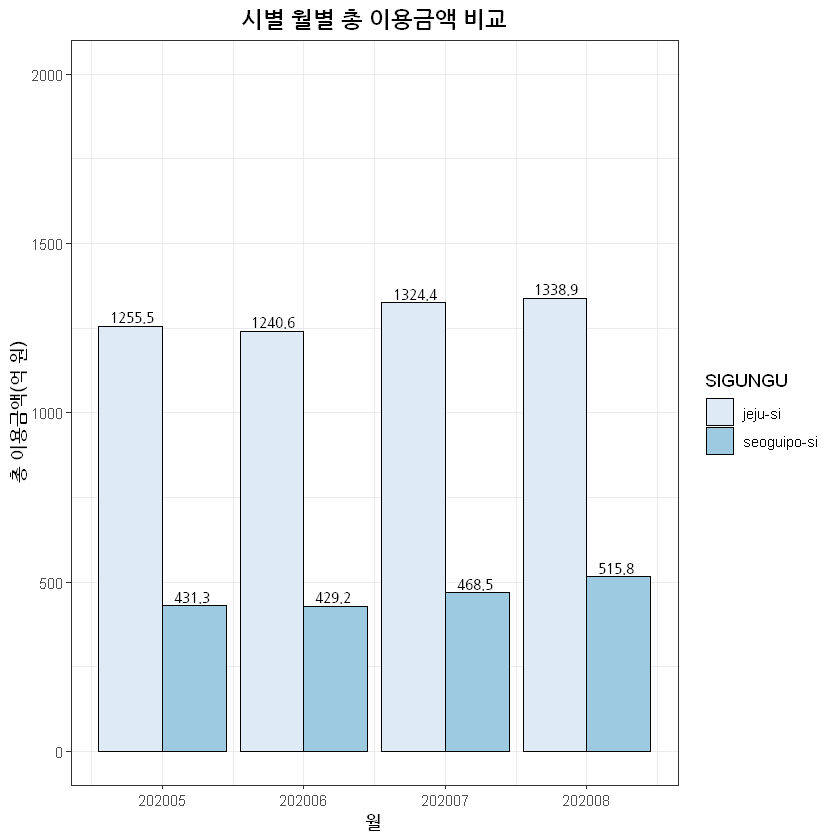

In [11]:
dat %>%
  group_by(SIGUNGU, YM) %>% 
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  ggplot(aes(x = YM, y = TotalSpent_sum, fill = SIGUNGU)) +
  geom_bar(stat='identity', position = 'dodge', color = 'black') +
  scale_fill_brewer(palette = 'Blues') +
  geom_text(aes(label=TotalSpent_sum), vjust=-0.4, size = 3, 
            position=position_dodge(.85),
            family = 'NanumGothic', fontface = 'bold') +
  theme_bw() +
  ggtitle("시별 월별 총 이용금액 비교") +
  labs(x = "월", y = "총 이용금액(억 원)") + 
  lims(y = c(0,2000)) +
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'))

### 읍면동별 총 이용금액 TOP10
여기서는 따로 법정읍면동 shp 파일과 제공된 데이터를 QGIS를 이용해서 교차분석을 통해 읍면동에 대한 좌표들을 매핑시켰습니다. 데이터는 구글드라이브에 공유해보도록 하겠습니다.
* 먼저 제주시와 서귀포를 나누지 않고 전체에 대한 총이용금액 TOP10인 읍면동을 시각화해봤습니다.
* 결과는 대부분이 제주시에 속해 있는 읍면동(연동~애월읍 등)이 차지하구요 이 중에 서귀포시인 서귀동과 안덕면이 TOP10안에 들어 갔네요

`summarise()` regrouping output by 'EMD_CD' (override with `.groups` argument)


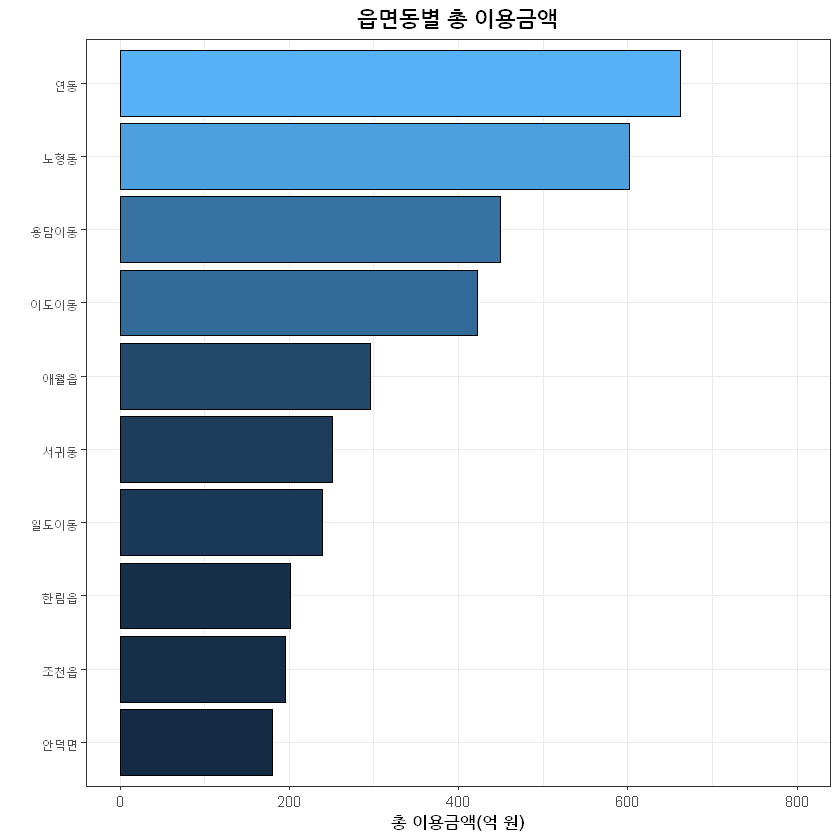

In [14]:
emd_total_df <- read.csv('total_spent-num_emd.csv')
emd_total_df %>%
  mutate(EMD_CD = as.character(EMD_CD)) %>%
  group_by(EMD_CD, EMD_KOR_NM) %>%
  summarise(TotalSpent_sum = sum(TotalSpent),
            DisSpent_sum = sum(DisSpent_s),
            NumofSpent_sum = sum(NumofSpent),
            NumofDisSpent_sum = sum(NumofDisSp)) -> emd_sum_df

emd_sum_df %>% arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(EMD_KOR_NM, TotalSpent_sum), y = TotalSpent_sum / 100000000, fill = TotalSpent_sum)) +
  geom_bar(stat = 'identity', color = 'black') +
  coord_flip() + theme_bw() +
  ggtitle("읍면동별 총 이용금액") +
  labs(x = "", y = "총 이용금액(억 원)") + 
  lims(y = c(0,800)) +
  theme(plot.title = element_text(size = 13, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 10, family = 'NanumGothic', face = 'bold'),
        axis.text.y = element_text(size = 9),
        legend.position = 'none')

### 제주시 읍면동 총 이용금액

* 제주시에서는 연동, 노형동, 용담이동, 이도이동, 애월읍 순으로 이용금액이 많다고 나타났습니다. 
* 연동과 노형은 인구수가 제주도에서 밀집되어 있는 지역이며, 많은 사람들의 왕래가 있고 가게들 그리고 면세점이 위치해 있기에 이용금액이 높게 나타난 것으로 생각합니다..

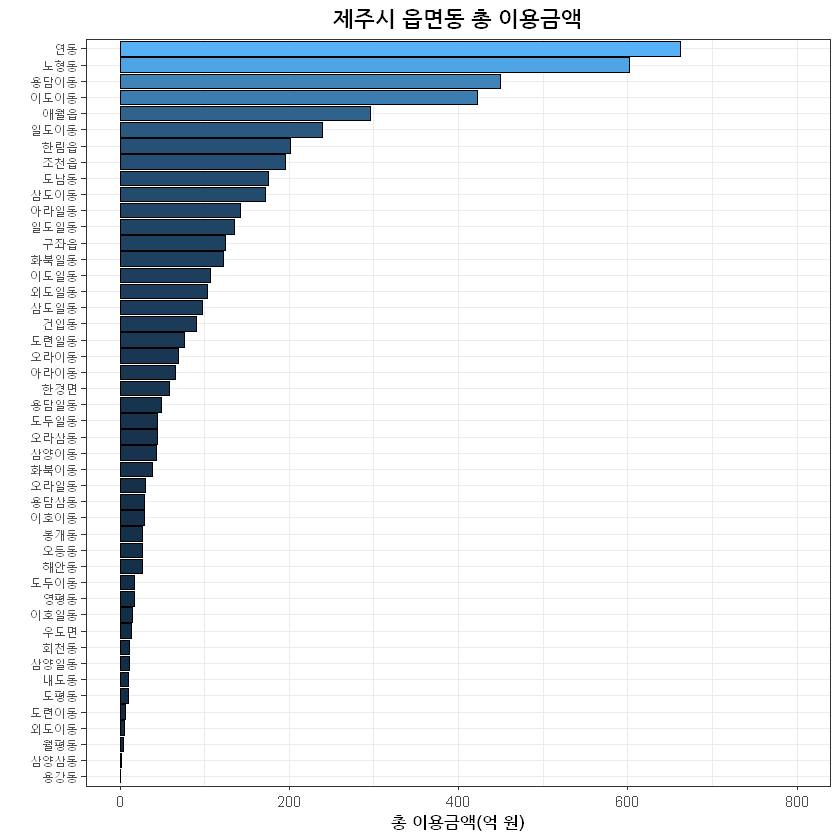

In [42]:
emd_sum_df %>%
  filter(substr(EMD_CD, 1, 4) == '5011') %>%
  ggplot(aes(x = reorder(EMD_KOR_NM, TotalSpent_sum), y = TotalSpent_sum / 100000000, fill = TotalSpent_sum)) +
  geom_bar(stat = 'identity', color = 'black') +
  coord_flip() + theme_bw() +
  ggtitle("제주시 읍면동 총 이용금액") +
  labs(x = "", y = "총 이용금액(억 원)") + 
  lims(y = c(0,800)) +
  theme(plot.title = element_text(size = 13, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 10, family = 'NanumGothic', face = 'bold'),
        axis.text.y = element_text(size = 7),
        legend.position = 'none')

### 서귀포시 읍면동 총 이용금액

* 서귀포시는 먼저 서귀포의 시내라고 할 수 있는 서귀동에서 많은 이용이 있는 것으로 보이구요. <br>그 다음 큰 안덕면, 성산읍 순으로 이용금액이 많은 걸 확인할 수 있습니다. (서귀포는 관광지가 많음으로 관광에 대한 소비가 많이 이뤄지는 곳입니다.)

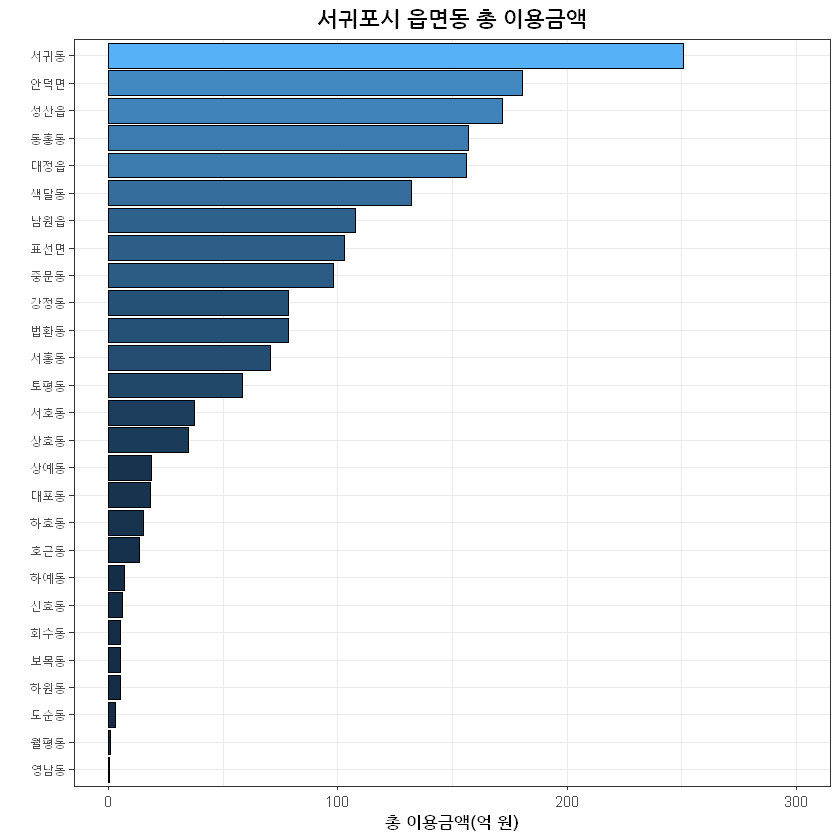

In [43]:
emd_sum_df %>%
  filter(substr(EMD_CD, 1, 4) == '5013') %>%
  ggplot(aes(x = reorder(EMD_KOR_NM, TotalSpent_sum), y = TotalSpent_sum / 100000000, fill = TotalSpent_sum)) +
  geom_bar(stat = 'identity', color = 'black') +
  coord_flip() + theme_bw() +
  ggtitle("서귀포시 읍면동 총 이용금액") +
  labs(x = "", y = "총 이용금액(억 원)") + 
  lims(y = c(0,300)) +
  theme(plot.title = element_text(size = 13, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 10, family = 'NanumGothic', face = 'bold'),
        axis.text.y = element_text(size = 7),
        legend.position = 'none')

### 월별 총 이용금액 비교

* 제주 월별로 총 이용금액의 추이를 살펴보기위해 시각화를 해봤습니다. <br>제주도의 성수기라고  할 수 있는 여름철에 7~8이 상승하는 것을 볼 수 있습니다. 코로나로 인해 2019년에 비해 총 이용금액이 많이 줄었기는 하지만 해외여행을 가지고 못하는 분들이 제주 여행을 대안으로 많이 오시기에 어느정도는 높게 유지 됐다고 생각합니다.

`summarise()` ungrouping output (override with `.groups` argument)


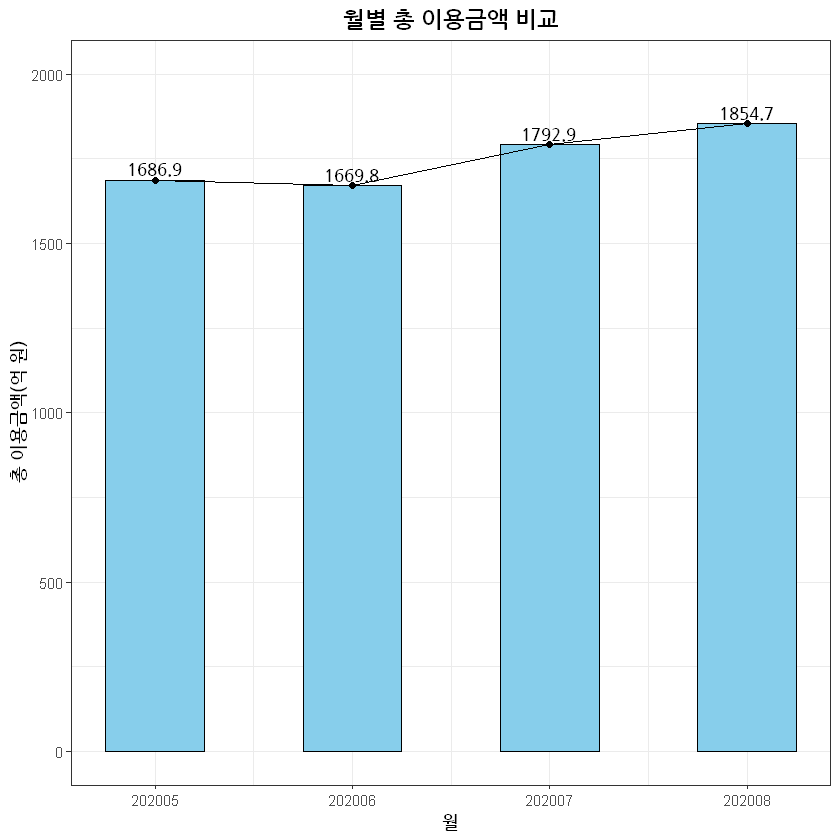

In [19]:
dat %>%
  group_by(YM) %>% 
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  ggplot(aes(x = as.numeric(YM), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.5, fill = 'skyblue') +
  geom_line() + geom_point() +
  geom_text(aes(label=TotalSpent_sum), vjust=-0.4, size = 3.5, family = 'NanumGothic', fontface = 'bold') +
  theme_bw() +
  ggtitle("월별 총 이용금액 비교") +
  labs(x = "월", y = "총 이용금액(억 원)") + 
  lims(y = c(0,2000)) +
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none')

### 월별 시간별 이용금액

* 이제 시간별로 총 이용금액의 추이를 살펴보겠습니다. <br>
아침 6시를 시작으로 12시까지 가파르게 증가하고 12시에 최고점을 찍은 후 조금씩 내려가다가 6~8시 저녁시간이 지난 시간에 뚝 떨어지는 패턴이 있습니다.<br> 많은 관광객과 도민들이 아침부터 오후까지의 소비가 가장 많이 이뤄지는거 같습니다.

`summarise()` regrouping output by 'YM' (override with `.groups` argument)


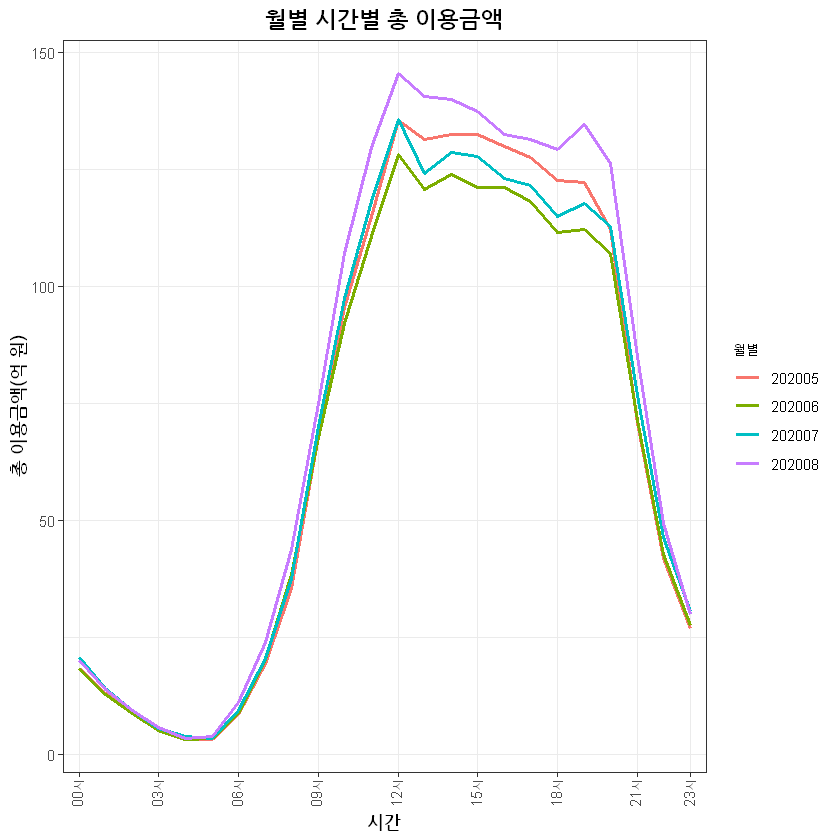

In [20]:
dat %>%
  filter(Time != 'x시') %>%
  group_by(YM, Time) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1)) %>%
  ggplot(aes(x = Time, y = TotalSpent_sum, group = as.character(YM), color = as.character(YM))) +
  geom_line(size = 1) +
  scale_x_discrete(breaks = c('00시', '03시','06시','09시', '12시','15시','18시', '21시', '23시')) + 
  scale_color_discrete(name="월별") +
  ggtitle("월별 시간별 총 이용금액") +
  labs(x = "시간", y = "총 이용금액(억 원)") +
  theme_bw() +
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        axis.text.x = element_text(angle = 90, vjust = 0.3, hjust = 0.5))

### 시간대별 이용금액

* 좀 더 간단하게 시간대별로 나타내보면 아침-점심-저녁의 9 to 18~저녁에 사람들의 소비가 이뤄집니다.

`summarise()` ungrouping output (override with `.groups` argument)


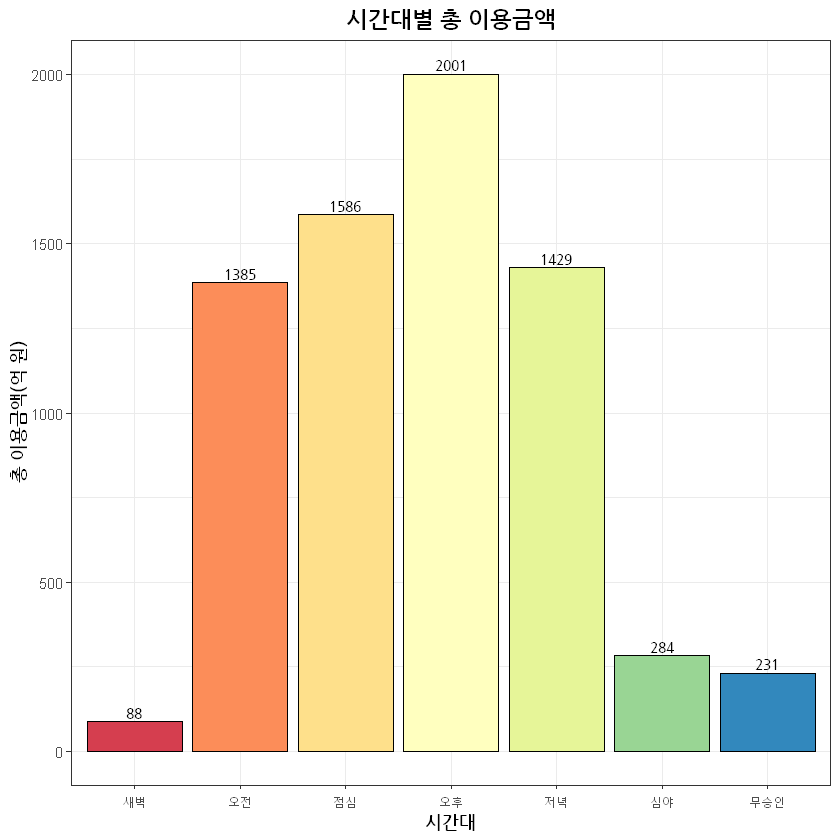

In [22]:
dat %>%
  group_by(timeName) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000),1) %>%
  ggplot(aes(x = timeName, y = TotalSpent_sum, fill = timeName)) +
  geom_bar(stat='identity', color = 'black') +
  geom_text(aes(label=TotalSpent_sum), vjust=-0.4, size = 3, 
            position=position_dodge(.85),
            family = 'NanumGothic', fontface = 'bold') +
  theme_bw() +
  scale_fill_brewer(palette = 'Spectral') +
  ggtitle("시간대별 총 이용금액") +
  labs(x = "시간대", y = "총 이용금액(억 원)") +
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none')

### 소상공인별 개수와 총 이용금액

* 소상공인타입별로 개수를 세어 봤는데요 월매출이 3억 이하인 영세 소상공인들이 월등히 많은걸 확인할 수 있습니다. 
* 그래서 당연히 총 이용금액은 영세 소상공인들이 높을 줄 알았으나, 일반(대형) 소상공인에서 총 이용금액이 가장 크게 나타났습니다. <br>
더 들어가 사람들이 어떤 업종에서 많이 쓰는지를 비교해봐야 정확한 결과를 알 수 있겠지만, 대형마트, 면세점에 대한 소비와 이용이 많은 걸로 추측해 볼 수 있습니다. 밑에서 살펴보도록하죠

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


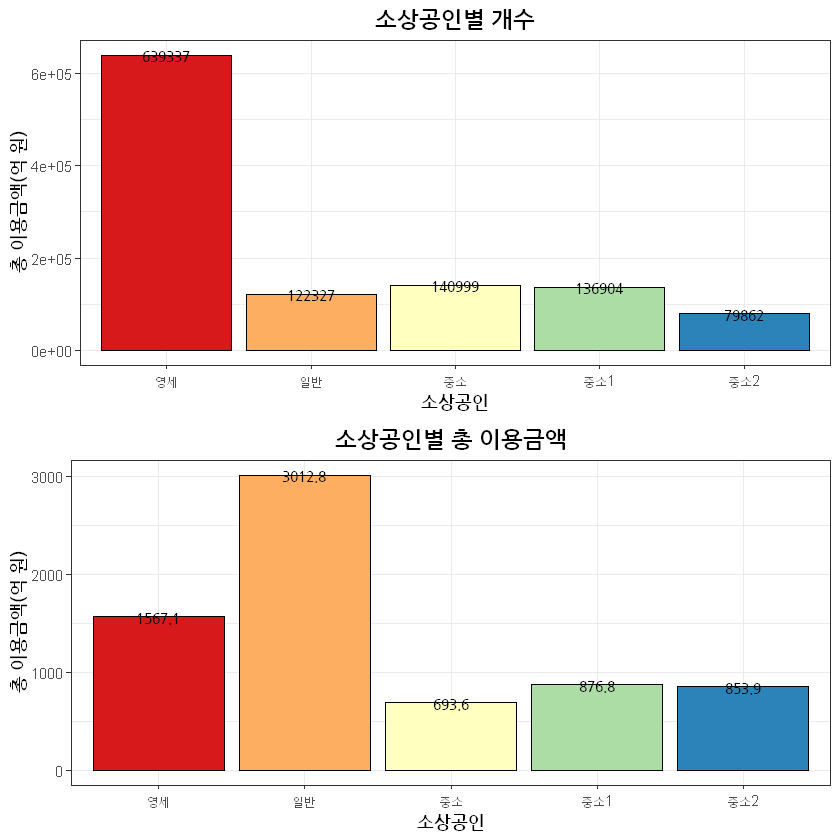

In [36]:
# 소상공인별 숫자
dat %>%
  group_by(FranClass) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = FranClass, y = n, fill = FranClass)) +
  geom_bar(stat='identity', color = 'black') +
  theme_bw() +
  scale_fill_brewer(palette = 'Spectral') +
  geom_text(aes(label=n), vjust= 0.5, size = 3, 
            position=position_dodge(.85),
            family = 'NanumGothic', fontface = 'bold') +
  theme_bw() +
  ggtitle("소상공인별 개수") +
  labs(x = "소상공인", y = "총 이용금액(억 원)") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p1

# 소상공인별 총 이용금액
dat %>%
  group_by(FranClass) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1)) %>%
  ggplot(aes(x = FranClass, y = TotalSpent_sum, fill = FranClass)) +
  geom_bar(stat='identity', color = 'black') +
  theme_bw() +
  scale_fill_brewer(palette = 'Spectral') +
  geom_text(aes(label=TotalSpent_sum), vjust=0.5, size = 3, 
            position=position_dodge(.85),
            family = 'NanumGothic', fontface = 'bold') +
  theme_bw() +
  ggtitle("소상공인별 총 이용금액") +
  labs(x = "소상공인", y = "총 이용금액(억 원)") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p2

grid.arrange(p1,p2)

### 큰 차이가 있는 소상공인 영세와 일반만 업종별로 비교해보자

* 영세 소상공인은 일반한식에 대한 소비가 월등히 높으며 다른 업종들은 대개 낮습니다. 하지만 일반(대형)은 영세에 비해
골고루 전체가 높으며, 대형마트(이마트, 롯데마트 등), 면세점, 주유소 등 사람들이 많이 찾고 소비하는 업종들이 분포가 많이 되어 있습니다.
<br> 영세는 대개 각 개인의 가게들로 이뤄져있지만 일반 대형은 프렌차이즈, 대기업들이 운영하는 곳이 많아 큰 차이가 있는 것으로 보입니다.

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


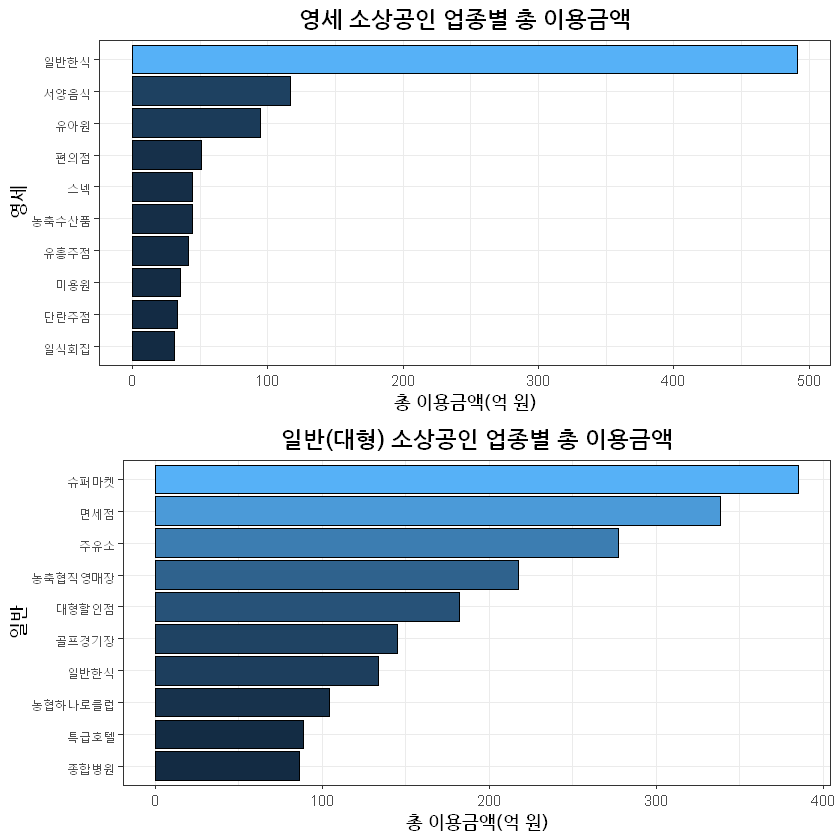

In [33]:
dat %>%
  filter(FranClass == '영세') %>%
  group_by(Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1)) %>%
  arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum, fill = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black') +
  theme_bw() +
  coord_flip() +
  ggtitle("영세 소상공인 업종별 총 이용금액") +
  labs(x = "영세", y = "총 이용금액(억 원)") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p1

dat %>%
  filter(FranClass == '일반') %>%
  group_by(Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1)) %>%
  arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum, fill = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black') +
  theme_bw() +
  coord_flip() +
  ggtitle("일반(대형) 소상공인 업종별 총 이용금액") +
  labs(x = "일반", y = "총 이용금액(억 원)") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p2

grid.arrange(p1,p2)

### 5~8월 총 이용금액 TOP10 업종

* 다시 다른 조건들을 제외한 5~8월에 소비한 총 이용금액 TOP10 업종을 살펴보겠습니다. <br>
아침,점심,저녁 등 끼니를 채울 수 있는 음식점 일반한식이 1등으로 자리 잡았고 그 다음으로 마켓, 편의점 그리고 면세점순으로 총 이용금액이 높게 나타났습니다.

`summarise()` ungrouping output (override with `.groups` argument)


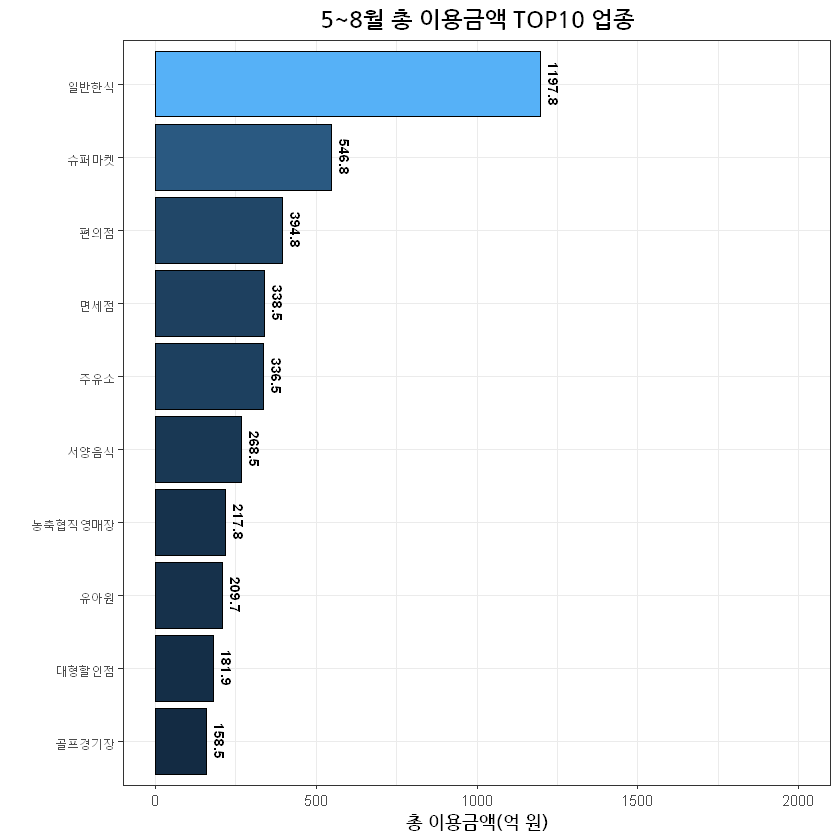

In [38]:
dat %>%
  group_by(Type) %>% 
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum, fill = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black') +
  geom_text(aes(label=TotalSpent_sum), vjust= -0.8,size=3,
            fontface = 'bold', angle = 270) +
  coord_flip() + 
  theme_bw() +
  ggtitle("5~8월 총 이용금액 TOP10 업종") +
  labs(x = "", y = "총 이용금액(억 원)") + 
  lims(y = c(0,2000)) +
  theme(plot.title = element_text(size = 14, family = 'NanumGothic', hjust = 0.5,face = 'bold'),
        axis.title = element_text(size = 11,family = 'NanumGothic', face = 'bold'),
        legend.position = 'none')

### 시별 이용금액 TOP10 업종

* 별다른 의미는 없지만 각 시마다 어떤 업종들에 차이가 있는지 확인하려보 시각화 해봤습니다. <br>
큰차이는 보이지않지만 제주시는 면세점, 서귀포시는 골프장, 호텔, 콘도에 차이를 보이고 있습니다. 서귀포 중문관광단지의 호텔들 그리고 골프장들이 많이 있어 차이가 있는거 같습니다.

`summarise()` regrouping output by 'SIGUNGU' (override with `.groups` argument)
`summarise()` regrouping output by 'SIGUNGU' (override with `.groups` argument)


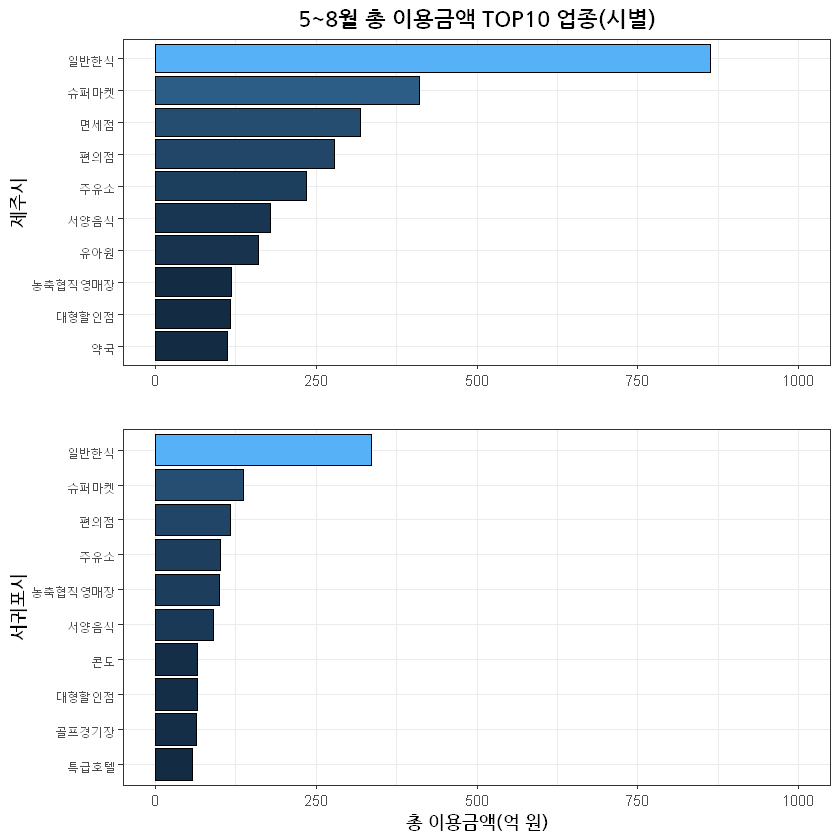

In [26]:
dat %>%
  group_by(SIGUNGU, Type) %>% 
  filter(SIGUNGU == 'jeju-si') %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum, fill = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black') +
  coord_flip() + 
  theme_bw() +
  ggtitle("5~8월 총 이용금액 TOP10 업종(시별)") +
  labs(x = "제주시", y = "") + 
  lims(y = c(0,1000)) +
  theme(plot.title = element_text(size = 13, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p1

dat %>%
  group_by(SIGUNGU, Type) %>% 
  filter(SIGUNGU == 'seoguipo-si') %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  arrange(desc(TotalSpent_sum)) %>% head(10) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum, fill = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black') +
  coord_flip() + 
  theme_bw() +
  labs(x = "서귀포시", y = "총 이용금액(억 원)") + 
  lims(y = c(0,1000)) +
  theme(axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p2
grid.arrange(p1,p2)

### 시간대별 업종 top5

* 이제 마지막으로 시간대별로 어떤 업종에서의 총 이용금액이 많은지 살펴보도록하고 마무리하겠습니다. 이건 그냥 눈으로 보고 판단할 수 있으리라 생각합니다

`summarise()` regrouping output by 'timeName' (override with `.groups` argument)
`summarise()` regrouping output by 'timeName' (override with `.groups` argument)
`summarise()` regrouping output by 'timeName' (override with `.groups` argument)


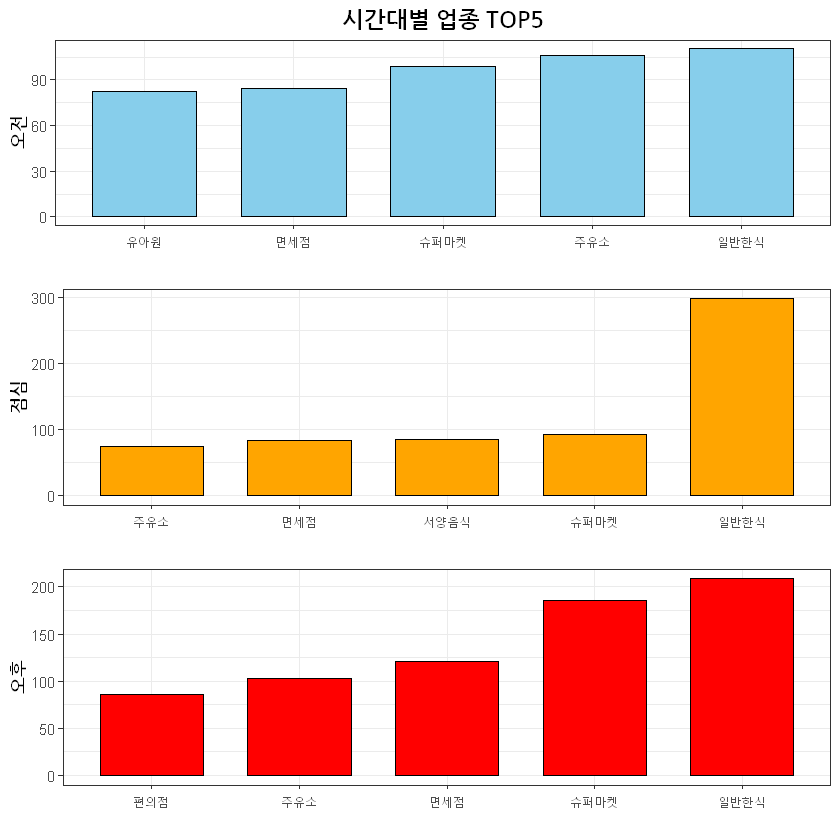

In [40]:
dat %>% 
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '오전') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7, fill = 'skyblue')  +
  theme_bw() +
  ggtitle("시간대별 업종 TOP5") +
  labs(x = "", y = "오전") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'),
        legend.position = 'none') -> p1
dat %>% 
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '점심') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7, fill = 'Orange')  +
  theme_bw() +
  labs(x = "", y = "점심") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold')) -> p2
dat %>% 
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '오후') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7, fill = 'Red')  +
  theme_bw() +
  labs(x = "", y = "오후") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold')) -> p3

grid.arrange(p1,p2,p3, nrow = 3)

`summarise()` regrouping output by 'timeName' (override with `.groups` argument)
`summarise()` regrouping output by 'timeName' (override with `.groups` argument)
`summarise()` regrouping output by 'timeName' (override with `.groups` argument)


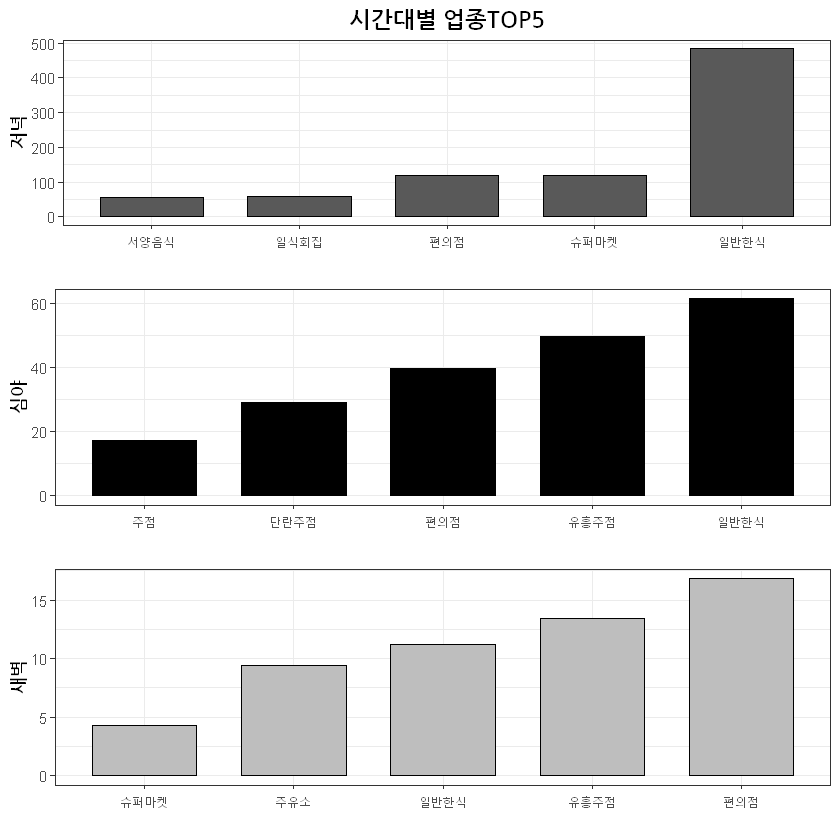

In [41]:
dat %>% 
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '저녁') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7)  +
  theme_bw() + 
  ggtitle("시간대별 업종TOP5") +
  labs(x = "", y = "저녁") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'))-> p4

dat %>% 
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '심야') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7, fill = 'black')  +
  theme_bw() + 
  labs(x = "", y = "심야") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'))-> p5
dat %>%  
  group_by(timeName, Type) %>%
  summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,1),
            DisSpent_sum = round(sum(DisSpent) / 100000000,1)) %>%
  mutate(DisSpent_ratio = round((DisSpent_sum / TotalSpent_sum),3)  * 100) %>%
  filter(timeName == '새벽') %>%
  arrange(desc(TotalSpent_sum)) %>% head(5) %>%
  ggplot(aes(x = reorder(Type, TotalSpent_sum), y = TotalSpent_sum)) +
  geom_bar(stat='identity', color = 'black', width = 0.7, fill = 'Gray')  +
  theme_bw() + 
  labs(x = "", y = "새벽") + 
  theme(plot.title = element_text(size = 14, hjust = 0.5, family = 'NanumGothic', face = 'bold'),
        axis.title = element_text(size = 11, family = 'NanumGothic', face = 'bold'))-> p6

grid.arrange(p4,p5,p6)
rm(p1,p2,p3,p4,p5,p6)

### 읍면동 R Shiny 시각화 (singleApp)

* R shiny에 대한 지식이 부족하여 좀 더 공부하고 다시 깔끔하게 업로드 할 수 있으면 해보겠습니다 <br>
현재는 단지 leaflet을 이용한 지도 시각화를 shiny상에 띄우기만 했습니다.
* 여기서 생각해볼만 한 것은 좌표점들이 격자내의 중심점 하나로 표현되었기 때문에 한점에 여러 소상공인들이 존재합니다. 그래서 따로 나눠서 생각해봐야한다고 생각합니다.

In [ ]:
library(shiny)
library(tidyverse)
library(leaflet)
library(leaflet.extras)
library(htmltools)
library(htmlwidgets)
library(RColorBrewer)
library(scales)
library(rgdal)
library(sp)
dat <- read.csv('KRI_DAC_Jeju.csv', fileEncoding = 'euc-kr')
dat %>%
    group_by(long, lat) %>%
    summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,2),
              DisSpent_sum = round(sum(DisSpent) / 100000000,2),
              NumofSpent_sum = sum(NumofSpent),
              NumofDisSpent_sum = sum(NumofDisSpent)) -> dat_longlat
#write.csv(dat_longlat, '5-8월_총이용금액+이용건수.csv')
dat %>%
    filter(FranClass == '일반' ) %>%
    group_by(Type, long, lat) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) -> jeju_big_type
dat %>%
    filter(FranClass == '영세' ) %>%
    group_by(Type, long, lat) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) -> jeju_small_type
dat %>%
    filter(FranClass == '중소' ) %>%
    group_by(Type, long, lat) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) -> jeju_mid1_type
dat %>%
    filter(FranClass == '중소1' ) %>%
    group_by(Type, long, lat) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) -> jeju_mid2_type
dat %>%
    filter(FranClass == '중소2' ) %>%
    group_by(Type, long, lat) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) -> jeju_mid3_type

#이용금액이 업종별 가장 많은 장소 TOP10 (제주시)
dat %>%
    filter(SIGUNGU == 'jeju-si') %>%
    group_by(Type,long,lat) %>%
    summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,2),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) %>% head(100) -> total_jejusi_top100_type

#이용금액이 업종별 가장 많은 장소 TOP10 (서귀포시)
dat %>%
    filter(SIGUNGU == 'seoguipo-si') %>%
    group_by(Type,long,lat) %>%
    summarise(TotalSpent_sum = round(sum(TotalSpent) / 100000000,2),
              NumofSpent_sum = sum(NumofSpent)) %>% 
    arrange(desc(TotalSpent_sum, NumofSpent_sum)) %>% head(100) -> total_seogui_top100_type

emd_total_df <- read.csv('total_spent-num_emd.csv', fileEncoding = 'euc-kr')
emd_total_df %>%
    mutate(EMD_CD = as.character(EMD_CD)) %>%
    group_by(EMD_CD, EMD_KOR_NM) %>%
    summarise(TotalSpent_sum = sum(TotalSpent),
              DisSpent_sum = sum(DisSpent_s),
              NumofSpent_sum = sum(NumofSpent),
              NumofDisSpent_sum = sum(NumofDisSp)) -> emd_sum_df

# 생산가능인구
jeju_emd_val <- readOGR('vl_blk.shp')
to.crs = CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
jeju_emd_val <- spTransform(jeju_emd_val, to.crs)
jeju_emd_val@data <- jeju_emd_val@data[,c('gid','val')]
jeju_emd_val@data <- rename(jeju_emd_val@data, "EMD_CD" = "gid")

jeju_emd <- readOGR('jeju_emd.shp', encoding = 'euc-kr')
to.crs = CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs") # 좌표변환
jeju_emd <- spTransform(jeju_emd, to.crs)
jeju_emd@data <- inner_join(jeju_emd@data, emd_sum_df)

jeju_emd@data <- inner_join(jeju_emd@data, jeju_emd_val@data)
head(jeju_emd@data) 
rm(jeju_emd_val); rm(emd_sum_df); rm(emd_total_df);

labels <- sprintf(
    "<strong>%s</strong><br/>총 %g억 원 <br>총 이용건수: %g <br>생산가능인구: %g",
    jeju_emd@data$EMD_KOR_NM, round(jeju_emd@data$TotalSpent_sum / 100000000,2), jeju_emd@data$NumofSpent_sum, jeju_emd@data$val
) %>% lapply(htmltools::HTML)
bins_spent <- c(0, 100, 200, 300, 400, 500, Inf)
bins_num <- c(1000, 5000, 10000, 50000, 100000, 500000, 1000000, Inf)
bins_pop <- c(0, 1000, 5000, 10000, 20000, 30000, Inf)
qpal <- colorQuantile('YlOrRd', domain = jeju_emd@data$NumofSpent_sum, n = 5 )
pal <- colorBin("YlOrRd", jeju_emd@data$TotalSpent_sum, bins = bins_spent)
pal2 <- colorBin("YlOrRd", jeju_emd@data$TotalSpent_sum, bins = bins_num)
pal3 <- colorBin("YlOrRd", jeju_emd@data$TotalSpent_sum, bins = bins_pop)

ui <-  fillPage(
    leafletOutput("mymap", width = "100%",height = "100%")
)

# Define server logic required to draw a histogram
server <- function(input, output) {
    output$mymap <- renderLeaflet({
        leaflet(jeju_emd) %>%
            setView(lng = 126.7229, lat = 33.40035, zoom = 10) %>%
            addTiles(group = "OSM(default)") %>%
            addCircleMarkers(data = jeju_small_type,
                             group = "소상공인_영세",
                             lng = ~long, lat = ~lat,
                             label = ~htmlEscape(Type), popup = ~paste0("총 ",comma(TotalSpent_sum, format = "d"),"원",
                                                                        "<br>",
                                                                        "총 이용건수: ",NumofSpent_sum,"건"),
                             radius = 5,
                             color = 'red',
                             stroke = FALSE, fillOpacity = 0.5) %>%
            addCircleMarkers(data = jeju_big_type,
                             group = "소상공인_일반",
                             lng = ~long, lat = ~lat,
                             label = ~htmlEscape(Type), popup = ~paste0("총 ",comma(TotalSpent_sum, format = "d"),"원",
                                                                        "<br>",
                                                                        "총 이용건수: ",NumofSpent_sum,"건"),
                             radius = 5,
                             color = 'blue',
                             stroke = FALSE, fillOpacity = 0.5) %>%
            addCircleMarkers(data = jeju_mid1_type,
                             group = "소상공인_중소1",
                             lng = ~long, lat = ~lat,
                             label = ~htmlEscape(Type), popup = ~paste0("총 ",comma(TotalSpent_sum, format = "d"),"원",
                                                                        "<br>",
                                                                        "총 이용건수: ",NumofSpent_sum,"건"),
                             radius = 5,
                             color = 'orange',
                             stroke = FALSE, fillOpacity = 0.5) %>%
            addCircleMarkers(data = jeju_mid2_type,
                             group = "소상공인_중소2",
                             lng = ~long, lat = ~lat,
                             label = ~htmlEscape(Type), popup = ~paste0("총 ",comma(TotalSpent_sum, format = "d"),"원",
                                                                        "<br>",
                                                                        "총 이용건수: ",NumofSpent_sum,"건"),
                             radius = 5,
                             color = 'green',
                             stroke = FALSE, fillOpacity = 0.5) %>%
            addCircleMarkers(data = jeju_mid3_type,
                             group = "소상공인_중소3",
                             lng = ~long, lat = ~lat,
                             label = ~htmlEscape(Type), popup = ~paste0("총 ",comma(TotalSpent_sum, format = "d"),"원",
                                                                        "<br>",
                                                                        "총 이용건수: ",NumofSpent_sum,"건"),
                             radius = 5,
                             color = 'skyblue',
                             stroke = FALSE, fillOpacity = 0.5) %>%
            
            
            addMarkers(data = total_jejusi_top100_type,
                       lng = ~long, lat = ~lat,
                       label = ~htmlEscape(Type), popup = ~paste0("약",as.character(TotalSpent_sum),"억원"),
                       group = "제주시 총이용금액 TOP100") %>%
            addMarkers(data = total_seogui_top100_type,
                       lng = ~long, lat = ~lat,
                       label = ~htmlEscape(Type), popup = ~paste0("약",as.character(TotalSpent_sum),"억원"),
                       group = '서귀포시 총이용금액 TOP100') %>%
            
            addHeatmap(data = dat_longlat,
                       lng = ~long, lat = ~lat,
                       intensity = ~NumofSpent_sum, blur = 30, max = 100000, radius = 20,
                       group = "총 이용건수 히트맵") %>%
            
            addHeatmap(data = dat_longlat,
                       lng = ~long, lat = ~lat,
                       intensity = ~TotalSpent_sum, blur = 30, max = 10, radius = 20,
                       group = "총 이용금액 히트맵") %>%
            
            addPolygons(data = jeju_emd,
                        group = "읍면동별_생산가능인구",
                        fillColor = ~pal3(val),
                        weight = 1,  opacity = 1, color = "black", dashArray = "1", fillOpacity = 0.7,
                        highlight = highlightOptions(
                            weight = 5,
                            color = "#666",
                            dashArray = "",
                            fillOpacity = 0.7,
                            bringToFront = TRUE),
                        label = labels,
                        labelOptions = labelOptions(
                            style = list("font-weight" = "normal", padding = "3px 8px"),
                            textsize = "15px",
                            direction = "auto")) %>% 
            addLegend(pal = pal3, values = ~val, opacity = 0.7, 
                      title = "생산가능인구",
                      labFormat = labelFormat(suffix = "명"),
                      position = "bottomleft",
                      group = "읍면동별_생산가능인구") %>%
            
            addPolygons(data = jeju_emd,
                        group = "읍면동별_총이용금액",
                        fillColor = ~pal(TotalSpent_sum / 100000000),
                        weight = 1,  opacity = 1, color = "black", dashArray = "1", fillOpacity = 0.7,
                        highlight = highlightOptions(
                            weight = 5,
                            color = "#666",
                            dashArray = "",
                            fillOpacity = 0.7,
                            bringToFront = TRUE),
                        label = labels,
                        labelOptions = labelOptions(
                            style = list("font-weight" = "normal", padding = "3px 8px"),
                            textsize = "15px",
                            direction = "auto")) %>% 
            addLegend(pal = pal, values = ~TotalSpent_sum / 100000000, opacity = 0.7, 
                      title = "총 이용금액",
                      labFormat = labelFormat(suffix = "억 원"),
                      position = "bottomleft",
                      group = "읍면동별_총이용금액") %>%
            
            addPolygons(data = jeju_emd,
                        group = "읍면동별_총이용건수",
                        fillColor = ~qpal(NumofSpent_sum),
                        weight = 1,
                        opacity = 1,
                        color = "black",
                        dashArray = "1",
                        fillOpacity = 0.7,
                        highlight = highlightOptions(
                            weight = 5,
                            color = "#666",
                            dashArray = "",
                            fillOpacity = 0.7,
                            bringToFront = TRUE),
                        label = labels,
                        labelOptions = labelOptions(
                            style = list("font-weight" = "normal", padding = "3px 8px"),
                            textsize = "15px",
                            direction = "auto")) %>% 
            addLegend(pal = pal2, values = ~NumofSpent_sum, opacity = 0.7, 
                      title = "총 이용건수",
                      labFormat = labelFormat(suffix = "건"),
                      position = "bottomleft",
                      group = "읍면동별_총이용건수") %>%
            
            addLayersControl(baseGroups = c("OSM(default)"),
                             overlayGroups = c("소상공인_영세","소상공인_일반","소상공인_중소1","소상공인_중소2","소상공인_중소3",
                                               "제주시 총이용금액 TOP100", "서귀포시 총이용금액 TOP100", 
                                               "총 이용건수 히트맵", "총 이용금액 히트맵",
                                               "읍면동별_생산가능인구", "읍면동별_총이용금액", "읍면동별_총이용건수"),
                             options = layersControlOptions(collapsed = FALSE)) %>%
            hideGroup(c("제주시 총이용금액 TOP100", "서귀포시 총이용금액 TOP100",
                        "총 이용건수 히트맵", "총 이용금액 히트맵", 
                        "읍면동별_총이용건수", "읍면동별_생산가능인구",
                        "소상공인_영세", "소상공인_일반","소상공인_중소1","소상공인_중소2","소상공인_중소3"))
    })
}

# Run the application 
shinyApp(ui = ui, server = server)
